let's start by downloading the Fashion-MNIST dataset and splitting it into training, validation, and test sets. We'll then proceed to normalize the images and implement the MLP as specified. I'll include the code for these steps, and ensure to follow all specified requirements.

Hyperparameter testing - Activation function LeakyRelu,Batch size - 128, Adam and SGD - 5 layers NN
input_size = 28 * 28
hidden_sizes = [256, 128, 64]
output_size = 10
learning_rate = 0.01

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Download the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 26421880/26421880 [00:03<00:00, 8139442.34it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 121523.25it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 482814.92it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6012886.94it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1])

48000
6000
6000
torch.Size([1, 28, 28])
1


Epoch 1/50, Train Loss: 7.4253, Val Loss: 7.4271, Train Acc: 0.7303, Val Acc: 0.7305
Epoch 2/50, Train Loss: 7.4396, Val Loss: 7.5345, Train Acc: 0.7289, Val Acc: 0.7247
Epoch 3/50, Train Loss: 6.7563, Val Loss: 6.9927, Train Acc: 0.7539, Val Acc: 0.7453
Epoch 4/50, Train Loss: 6.7385, Val Loss: 6.9270, Train Acc: 0.7543, Val Acc: 0.7473
Epoch 5/50, Train Loss: 7.2455, Val Loss: 7.1137, Train Acc: 0.7354, Val Acc: 0.7403
Epoch 6/50, Train Loss: 6.5164, Val Loss: 6.7744, Train Acc: 0.7620, Val Acc: 0.7523
Epoch 7/50, Train Loss: 6.9125, Val Loss: 6.9491, Train Acc: 0.7477, Val Acc: 0.7467
Epoch 8/50, Train Loss: 6.1980, Val Loss: 6.3434, Train Acc: 0.7738, Val Acc: 0.7683
Epoch 9/50, Train Loss: 6.5283, Val Loss: 6.8096, Train Acc: 0.7614, Val Acc: 0.7518
Epoch 10/50, Train Loss: 6.3140, Val Loss: 6.4750, Train Acc: 0.7689, Val Acc: 0.7630
Epoch 11/50, Train Loss: 5.7702, Val Loss: 5.8837, Train Acc: 0.7886, Val Acc: 0.7842
Epoch 12/50, Train Loss: 6.3112, Val Loss: 6.2118, Train Acc: 0

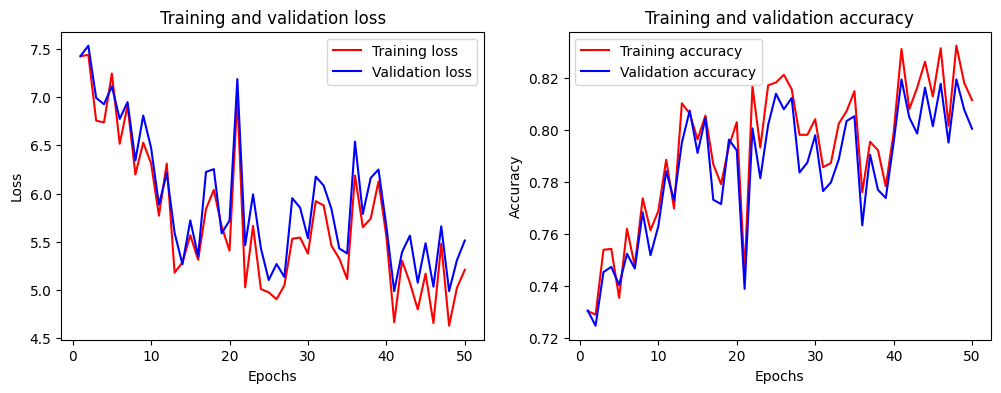

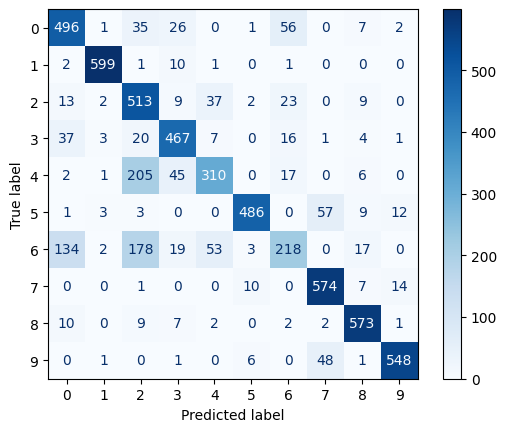

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Implementing functions from scratch using numpy

# Define activation functions and their derivatives
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-12, 1.0)
    log_p = -np.log(y_pred[range(n_samples), y_true.argmax(axis=1)])
    loss = np.sum(log_p) / n_samples
    return loss

def cross_entropy_loss_derivative(y_true, y_pred):
    n_samples = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(n_samples), y_true.argmax(axis=1)] -= 1
    grad = grad / n_samples
    return grad

def batch_norm_forward(x, gamma, beta, eps=1e-8):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    x_norm = (x - mean) / np.sqrt(var + eps)
    out = gamma * x_norm + beta
    cache = (x, x_norm, mean, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    x, x_norm, mean, var, gamma, beta, eps = cache
    N, D = x.shape

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_norm, axis=0)
    dx_norm = dout * gamma
    dvar = np.sum(dx_norm * (x - mean) * -0.5 * np.power(var + eps, -1.5), axis=0)
    dmean = np.sum(dx_norm * -1.0 / np.sqrt(var + eps), axis=0) + dvar * np.sum(-2.0 * (x - mean), axis=0) / N
    dx = dx_norm * 1.0 / np.sqrt(var + eps) + dvar * 2.0 * (x - mean) / N + dmean / N

    return dx, dgamma, dbeta

# Implement MLP class

class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, dropout_rates=None):
        self.learning_rate = learning_rate
        self.dropout_rates = dropout_rates if dropout_rates else [0.1] * (len(hidden_sizes) + 1)
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.gammas = [np.ones((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.betas = [np.zeros((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.velocities = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]
        self.squares = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]

    def forward(self, x):
        self.caches = []
        self.norm_caches = []
        self.dropouts = []

        x = x * (np.random.rand(*x.shape) > self.dropout_rates[0]) / (1 - self.dropout_rates[0])
        self.dropouts.append(x)

        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            norm_z, norm_cache = batch_norm_forward(z, self.gammas[i], self.betas[i])
            a = leaky_relu(norm_z)
            dropout_mask = (np.random.rand(*a.shape) > self.dropout_rates[i+1]) / (1 - self.dropout_rates[i+1])
            a = a * dropout_mask
            self.caches.append((x, z, norm_cache))
            self.dropouts.append(dropout_mask)
            x = a

        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        a = softmax(z)
        self.caches.append((x, z))
        return a

    def backward(self, y_true, y_pred):
        m = y_true.shape[0]
        grads = {}
        d_a = cross_entropy_loss_derivative(y_true, y_pred)

        for i in reversed(range(len(self.weights))):
            x, z, *cache = self.caches[i]
            if i == len(self.weights) - 1:
                d_z = d_a
            else:
                d_z = d_a * leaky_relu_derivative(z)
                d_z, dgamma, dbeta = batch_norm_backward(d_z, cache[0])
                grads[f'dgamma{i}'] = dgamma
                grads[f'dbeta{i}'] = dbeta

            grads[f'dw{i}'] = np.dot(x.T, d_z) / m
            grads[f'db{i}'] = np.sum(d_z, axis=0, keepdims=True) / m

            if i != 0:
                d_a = np.dot(d_z, self.weights[i].T)
                if len(self.dropouts) > i:
                    d_a = d_a * self.dropouts[i]

        return grads

    def update_weights(self, grads, t, optimizer='adam'):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        lr = self.learning_rate
        for i in range(len(self.weights)):
            if optimizer == 'adam':
                self.velocities[i]['dw'] = beta1 * self.velocities[i]['dw'] + (1 - beta1) * grads[f'dw{i}']
                self.velocities[i]['db'] = beta1 * self.velocities[i]['db'] + (1 - beta1) * grads[f'db{i}']
                self.squares[i]['dw'] = beta2 * self.squares[i]['dw'] + (1 - beta2) * (grads[f'dw{i}'] ** 2)
                self.squares[i]['db'] = beta2 * self.squares[i]['db'] + (1 - beta2) * (grads[f'db{i}'] ** 2)
                m_hat_dw = self.velocities[i]['dw'] / (1 - beta1 ** t)
                m_hat_db = self.velocities[i]['db'] / (1 - beta1 ** t)
                v_hat_dw = self.squares[i]['dw'] / (1 - beta2 ** t)
                v_hat_db = self.squares[i]['db'] / (1 - beta2 ** t)
                self.weights[i] -= lr * m_hat_dw / (np.sqrt(v_hat_dw) + eps)
                self.biases[i] -= lr * m_hat_db / (np.sqrt(v_hat_db) + eps)
                if i < len(self.weights) - 1:
                    v_hat_gamma = self.squares[i]['dgamma'] / (1 - beta2 ** t)
                    v_hat_beta = self.squares[i]['dbeta'] / (1 - beta2 ** t)
                    self.gammas[i] -= lr * grads[f'dgamma{i}'] / (np.sqrt(v_hat_gamma) + eps)
                    self.betas[i] -= lr * grads[f'dbeta{i}'] / (np.sqrt(v_hat_beta) + eps)
            else:  # SGD
                self.weights[i] -= lr * grads[f'dw{i}']
                self.biases[i] -= lr * grads[f'db{i}']
                if i < len(self.weights) - 1:
                    self.gammas[i] -= lr * grads[f'dgamma{i}']
                    self.betas[i] -= lr * grads[f'dbeta{i}']

    def train(self, x_train, y_train, x_val, y_val, epochs=30, batch_size=128):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            optimizer = 'adam' if epoch < 30 else 'sgd'  # Switch to SGD after 30 epochs
            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward(x_batch)
                grads = self.backward(y_batch, y_pred)
                self.update_weights(grads, epoch + 1, optimizer=optimizer)

            train_loss, train_acc = self.evaluate(x_train, y_train)
            val_loss, val_acc = self.evaluate(x_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        return train_losses, val_losses, train_accuracies, val_accuracies

    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == y.argmax(axis=1))
        return loss, accuracy

    def predict(self, x):
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)

# Helper function to prepare data for the MLP
def prepare_data(loader):
    x_list, y_list = [], []
    for x, y in loader:
        x_list.append(x.view(x.size(0), -1).numpy())
        y_list.append(np.eye(10)[y.numpy()])
    return np.vstack(x_list), np.vstack(y_list)

x_train, y_train = prepare_data(train_loader)
x_val, y_val = prepare_data(val_loader)
x_test, y_test = prepare_data(test_loader)

# Instantiate and train the MLP
input_size = 28 * 28
hidden_sizes = [256, 128, 64]
output_size = 10
learning_rate = 0.01
mlp = MLP(input_size, hidden_sizes, output_size, learning_rate)

train_losses, val_losses, train_accuracies, val_accuracies = mlp.train(x_train, y_train, x_val, y_val, epochs=50)

# Evaluate on test data
test_loss, test_accuracy = mlp.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotting results
epochs = range(1, 51)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
y_pred_test = mlp.predict(x_test)
y_true_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()


In the second case i used SGD first and then ADAM - accuracy 77%

Epoch 1/50, Train Loss: 1.9466, Val Loss: 1.9257, Train Acc: 0.3039, Val Acc: 0.3137
Epoch 2/50, Train Loss: 1.5378, Val Loss: 1.5275, Train Acc: 0.4902, Val Acc: 0.5003
Epoch 3/50, Train Loss: 1.3299, Val Loss: 1.3146, Train Acc: 0.5637, Val Acc: 0.5698
Epoch 4/50, Train Loss: 1.2036, Val Loss: 1.1963, Train Acc: 0.6000, Val Acc: 0.6065
Epoch 5/50, Train Loss: 1.1102, Val Loss: 1.1075, Train Acc: 0.6306, Val Acc: 0.6373
Epoch 6/50, Train Loss: 1.0436, Val Loss: 1.0330, Train Acc: 0.6502, Val Acc: 0.6510
Epoch 7/50, Train Loss: 0.9913, Val Loss: 0.9790, Train Acc: 0.6651, Val Acc: 0.6713
Epoch 8/50, Train Loss: 0.9478, Val Loss: 0.9489, Train Acc: 0.6792, Val Acc: 0.6715
Epoch 9/50, Train Loss: 0.9133, Val Loss: 0.9081, Train Acc: 0.6901, Val Acc: 0.6853
Epoch 10/50, Train Loss: 0.8872, Val Loss: 0.8795, Train Acc: 0.6955, Val Acc: 0.6962
Epoch 11/50, Train Loss: 0.8655, Val Loss: 0.8682, Train Acc: 0.7022, Val Acc: 0.6982
Epoch 12/50, Train Loss: 0.8426, Val Loss: 0.8384, Train Acc: 0

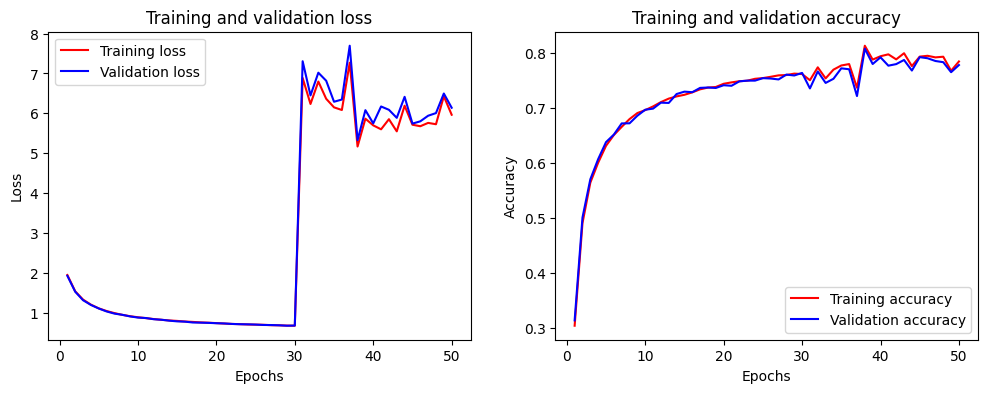

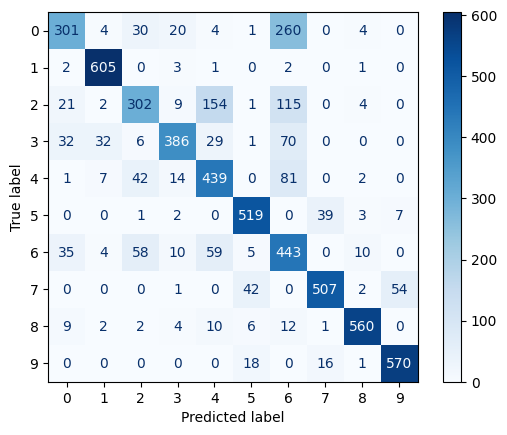

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Implementing functions from scratch using numpy

# Define activation functions and their derivatives
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-12, 1.0)
    log_p = -np.log(y_pred[range(n_samples), y_true.argmax(axis=1)])
    loss = np.sum(log_p) / n_samples
    return loss

def cross_entropy_loss_derivative(y_true, y_pred):
    n_samples = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(n_samples), y_true.argmax(axis=1)] -= 1
    grad = grad / n_samples
    return grad

def batch_norm_forward(x, gamma, beta, eps=1e-8):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    x_norm = (x - mean) / np.sqrt(var + eps)
    out = gamma * x_norm + beta
    cache = (x, x_norm, mean, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    x, x_norm, mean, var, gamma, beta, eps = cache
    N, D = x.shape

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_norm, axis=0)
    dx_norm = dout * gamma
    dvar = np.sum(dx_norm * (x - mean) * -0.5 * np.power(var + eps, -1.5), axis=0)
    dmean = np.sum(dx_norm * -1.0 / np.sqrt(var + eps), axis=0) + dvar * np.sum(-2.0 * (x - mean), axis=0) / N
    dx = dx_norm * 1.0 / np.sqrt(var + eps) + dvar * 2.0 * (x - mean) / N + dmean / N

    return dx, dgamma, dbeta

# Implement MLP class

class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, dropout_rates=None):
        self.learning_rate = learning_rate
        self.dropout_rates = dropout_rates if dropout_rates else [0.1] * (len(hidden_sizes) + 1)
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.gammas = [np.ones((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.betas = [np.zeros((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.velocities = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]
        self.squares = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]

    def forward(self, x):
        self.caches = []
        self.norm_caches = []
        self.dropouts = []

        x = x * (np.random.rand(*x.shape) > self.dropout_rates[0]) / (1 - self.dropout_rates[0])
        self.dropouts.append(x)

        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            norm_z, norm_cache = batch_norm_forward(z, self.gammas[i], self.betas[i])
            a = leaky_relu(norm_z)
            dropout_mask = (np.random.rand(*a.shape) > self.dropout_rates[i+1]) / (1 - self.dropout_rates[i+1])
            a = a * dropout_mask
            self.caches.append((x, z, norm_cache))
            self.dropouts.append(dropout_mask)
            x = a

        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        a = softmax(z)
        self.caches.append((x, z))
        return a

    def backward(self, y_true, y_pred):
        m = y_true.shape[0]
        grads = {}
        d_a = cross_entropy_loss_derivative(y_true, y_pred)

        for i in reversed(range(len(self.weights))):
            x, z, *cache = self.caches[i]
            if i == len(self.weights) - 1:
                d_z = d_a
            else:
                d_z = d_a * leaky_relu_derivative(z)
                d_z, dgamma, dbeta = batch_norm_backward(d_z, cache[0])
                grads[f'dgamma{i}'] = dgamma
                grads[f'dbeta{i}'] = dbeta

            grads[f'dw{i}'] = np.dot(x.T, d_z) / m
            grads[f'db{i}'] = np.sum(d_z, axis=0, keepdims=True) / m

            if i != 0:
                d_a = np.dot(d_z, self.weights[i].T)
                if len(self.dropouts) > i:
                    d_a = d_a * self.dropouts[i]

        return grads

    def update_weights(self, grads, t, optimizer='adam'):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        lr = self.learning_rate
        for i in range(len(self.weights)):
            if optimizer == 'adam':
                self.velocities[i]['dw'] = beta1 * self.velocities[i]['dw'] + (1 - beta1) * grads[f'dw{i}']
                self.velocities[i]['db'] = beta1 * self.velocities[i]['db'] + (1 - beta1) * grads[f'db{i}']
                self.squares[i]['dw'] = beta2 * self.squares[i]['dw'] + (1 - beta2) * (grads[f'dw{i}'] ** 2)
                self.squares[i]['db'] = beta2 * self.squares[i]['db'] + (1 - beta2) * (grads[f'db{i}'] ** 2)
                m_hat_dw = self.velocities[i]['dw'] / (1 - beta1 ** t)
                m_hat_db = self.velocities[i]['db'] / (1 - beta1 ** t)
                v_hat_dw = self.squares[i]['dw'] / (1 - beta2 ** t)
                v_hat_db = self.squares[i]['db'] / (1 - beta2 ** t)
                self.weights[i] -= lr * m_hat_dw / (np.sqrt(v_hat_dw) + eps)
                self.biases[i] -= lr * m_hat_db / (np.sqrt(v_hat_db) + eps)
                if i < len(self.weights) - 1:
                    v_hat_gamma = self.squares[i]['dgamma'] / (1 - beta2 ** t)
                    v_hat_beta = self.squares[i]['dbeta'] / (1 - beta2 ** t)
                    self.gammas[i] -= lr * grads[f'dgamma{i}'] / (np.sqrt(v_hat_gamma) + eps)
                    self.betas[i] -= lr * grads[f'dbeta{i}'] / (np.sqrt(v_hat_beta) + eps)
            else:  # SGD
                self.weights[i] -= lr * grads[f'dw{i}']
                self.biases[i] -= lr * grads[f'db{i}']
                if i < len(self.weights) - 1:
                    self.gammas[i] -= lr * grads[f'dgamma{i}']
                    self.betas[i] -= lr * grads[f'dbeta{i}']

    def train(self, x_train, y_train, x_val, y_val, epochs=50, batch_size=64):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            optimizer = 'sgd' if epoch < 30 else 'adam'  # Switch to adam after 30 epochs
            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward(x_batch)
                grads = self.backward(y_batch, y_pred)
                self.update_weights(grads, epoch + 1, optimizer=optimizer)

            train_loss, train_acc = self.evaluate(x_train, y_train)
            val_loss, val_acc = self.evaluate(x_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        return train_losses, val_losses, train_accuracies, val_accuracies

    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == y.argmax(axis=1))
        return loss, accuracy

    def predict(self, x):
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)

# Helper function to prepare data for the MLP
def prepare_data(loader):
    x_list, y_list = [], []
    for x, y in loader:
        x_list.append(x.view(x.size(0), -1).numpy())
        y_list.append(np.eye(10)[y.numpy()])
    return np.vstack(x_list), np.vstack(y_list)

x_train, y_train = prepare_data(train_loader)
x_val, y_val = prepare_data(val_loader)
x_test, y_test = prepare_data(test_loader)

# Instantiate and train the MLP - Changes here to only one hidden layer
input_size = 28 * 28
hidden_sizes = [128]
output_size = 10
learning_rate = 0.01
mlp = MLP(input_size, hidden_sizes, output_size, learning_rate)

train_losses, val_losses, train_accuracies, val_accuracies = mlp.train(x_train, y_train, x_val, y_val, epochs=50)

# Evaluate on test data
test_loss, test_accuracy = mlp.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotting results
epochs = range(1, 51)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
y_pred_test = mlp.predict(x_test)
y_true_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()


Third test - with all three layers and sgd followd by adam

Epoch 1/50, Train Loss: 2.0542, Val Loss: 2.0567, Train Acc: 0.2780, Val Acc: 0.2793
Epoch 2/50, Train Loss: 1.7513, Val Loss: 1.7525, Train Acc: 0.4043, Val Acc: 0.4058
Epoch 3/50, Train Loss: 1.5574, Val Loss: 1.5542, Train Acc: 0.4785, Val Acc: 0.4863
Epoch 4/50, Train Loss: 1.4152, Val Loss: 1.4226, Train Acc: 0.5316, Val Acc: 0.5257
Epoch 5/50, Train Loss: 1.3078, Val Loss: 1.2954, Train Acc: 0.5645, Val Acc: 0.5655
Epoch 6/50, Train Loss: 1.2273, Val Loss: 1.2242, Train Acc: 0.5874, Val Acc: 0.5925
Epoch 7/50, Train Loss: 1.1644, Val Loss: 1.1537, Train Acc: 0.6052, Val Acc: 0.6128
Epoch 8/50, Train Loss: 1.1029, Val Loss: 1.1077, Train Acc: 0.6251, Val Acc: 0.6253
Epoch 9/50, Train Loss: 1.0621, Val Loss: 1.0626, Train Acc: 0.6374, Val Acc: 0.6348
Epoch 10/50, Train Loss: 1.0254, Val Loss: 1.0140, Train Acc: 0.6466, Val Acc: 0.6458
Epoch 11/50, Train Loss: 0.9895, Val Loss: 0.9789, Train Acc: 0.6551, Val Acc: 0.6612
Epoch 12/50, Train Loss: 0.9636, Val Loss: 0.9561, Train Acc: 0

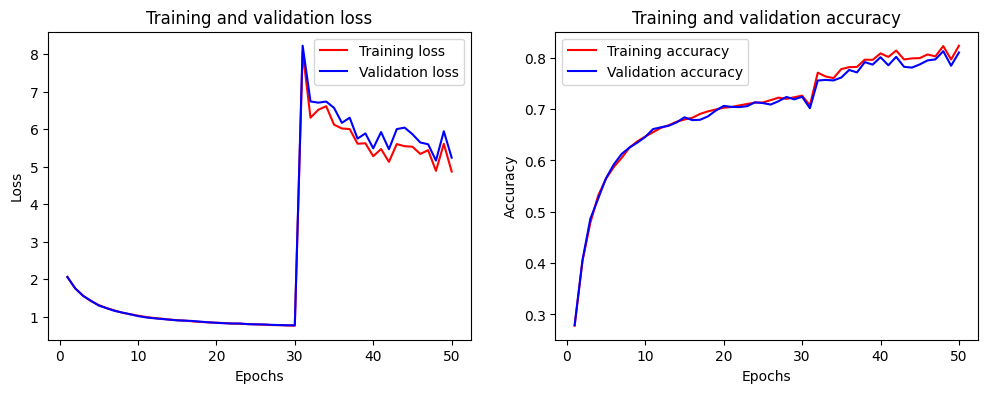

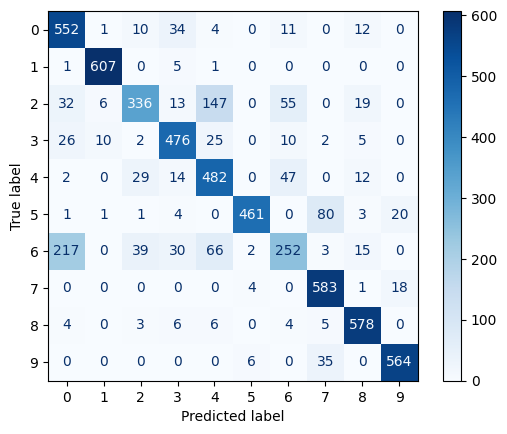

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Implementing functions from scratch using numpy

# Define activation functions and their derivatives
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-12, 1.0)
    log_p = -np.log(y_pred[range(n_samples), y_true.argmax(axis=1)])
    loss = np.sum(log_p) / n_samples
    return loss

def cross_entropy_loss_derivative(y_true, y_pred):
    n_samples = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(n_samples), y_true.argmax(axis=1)] -= 1
    grad = grad / n_samples
    return grad

def batch_norm_forward(x, gamma, beta, eps=1e-8):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    x_norm = (x - mean) / np.sqrt(var + eps)
    out = gamma * x_norm + beta
    cache = (x, x_norm, mean, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    x, x_norm, mean, var, gamma, beta, eps = cache
    N, D = x.shape

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_norm, axis=0)
    dx_norm = dout * gamma
    dvar = np.sum(dx_norm * (x - mean) * -0.5 * np.power(var + eps, -1.5), axis=0)
    dmean = np.sum(dx_norm * -1.0 / np.sqrt(var + eps), axis=0) + dvar * np.sum(-2.0 * (x - mean), axis=0) / N
    dx = dx_norm * 1.0 / np.sqrt(var + eps) + dvar * 2.0 * (x - mean) / N + dmean / N

    return dx, dgamma, dbeta

# Implement MLP class

class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, dropout_rates=None):
        self.learning_rate = learning_rate
        self.dropout_rates = dropout_rates if dropout_rates else [0.1] * (len(hidden_sizes) + 1)
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.gammas = [np.ones((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.betas = [np.zeros((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.velocities = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]
        self.squares = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]

    def forward(self, x):
        self.caches = []
        self.norm_caches = []
        self.dropouts = []

        x = x * (np.random.rand(*x.shape) > self.dropout_rates[0]) / (1 - self.dropout_rates[0])
        self.dropouts.append(x)

        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            norm_z, norm_cache = batch_norm_forward(z, self.gammas[i], self.betas[i])
            a = leaky_relu(norm_z)
            dropout_mask = (np.random.rand(*a.shape) > self.dropout_rates[i+1]) / (1 - self.dropout_rates[i+1])
            a = a * dropout_mask
            self.caches.append((x, z, norm_cache))
            self.dropouts.append(dropout_mask)
            x = a

        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        a = softmax(z)
        self.caches.append((x, z))
        return a

    def backward(self, y_true, y_pred):
        m = y_true.shape[0]
        grads = {}
        d_a = cross_entropy_loss_derivative(y_true, y_pred)

        for i in reversed(range(len(self.weights))):
            x, z, *cache = self.caches[i]
            if i == len(self.weights) - 1:
                d_z = d_a
            else:
                d_z = d_a * leaky_relu_derivative(z)
                d_z, dgamma, dbeta = batch_norm_backward(d_z, cache[0])
                grads[f'dgamma{i}'] = dgamma
                grads[f'dbeta{i}'] = dbeta

            grads[f'dw{i}'] = np.dot(x.T, d_z) / m
            grads[f'db{i}'] = np.sum(d_z, axis=0, keepdims=True) / m

            if i != 0:
                d_a = np.dot(d_z, self.weights[i].T)
                if len(self.dropouts) > i:
                    d_a = d_a * self.dropouts[i]

        return grads

    def update_weights(self, grads, t, optimizer='adam'):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        lr = self.learning_rate
        for i in range(len(self.weights)):
            if optimizer == 'adam':
                self.velocities[i]['dw'] = beta1 * self.velocities[i]['dw'] + (1 - beta1) * grads[f'dw{i}']
                self.velocities[i]['db'] = beta1 * self.velocities[i]['db'] + (1 - beta1) * grads[f'db{i}']
                self.squares[i]['dw'] = beta2 * self.squares[i]['dw'] + (1 - beta2) * (grads[f'dw{i}'] ** 2)
                self.squares[i]['db'] = beta2 * self.squares[i]['db'] + (1 - beta2) * (grads[f'db{i}'] ** 2)
                m_hat_dw = self.velocities[i]['dw'] / (1 - beta1 ** t)
                m_hat_db = self.velocities[i]['db'] / (1 - beta1 ** t)
                v_hat_dw = self.squares[i]['dw'] / (1 - beta2 ** t)
                v_hat_db = self.squares[i]['db'] / (1 - beta2 ** t)
                self.weights[i] -= lr * m_hat_dw / (np.sqrt(v_hat_dw) + eps)
                self.biases[i] -= lr * m_hat_db / (np.sqrt(v_hat_db) + eps)
                if i < len(self.weights) - 1:
                    v_hat_gamma = self.squares[i]['dgamma'] / (1 - beta2 ** t)
                    v_hat_beta = self.squares[i]['dbeta'] / (1 - beta2 ** t)
                    self.gammas[i] -= lr * grads[f'dgamma{i}'] / (np.sqrt(v_hat_gamma) + eps)
                    self.betas[i] -= lr * grads[f'dbeta{i}'] / (np.sqrt(v_hat_beta) + eps)
            else:  # SGD
                self.weights[i] -= lr * grads[f'dw{i}']
                self.biases[i] -= lr * grads[f'db{i}']
                if i < len(self.weights) - 1:
                    self.gammas[i] -= lr * grads[f'dgamma{i}']
                    self.betas[i] -= lr * grads[f'dbeta{i}']

    def train(self, x_train, y_train, x_val, y_val, epochs=30, batch_size=64):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            optimizer = 'sgd' if epoch < 30 else 'adam'  # Switch to adam after 30 epochs
            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward(x_batch)
                grads = self.backward(y_batch, y_pred)
                self.update_weights(grads, epoch + 1, optimizer=optimizer)

            train_loss, train_acc = self.evaluate(x_train, y_train)
            val_loss, val_acc = self.evaluate(x_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        return train_losses, val_losses, train_accuracies, val_accuracies

    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == y.argmax(axis=1))
        return loss, accuracy

    def predict(self, x):
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)

# Helper function to prepare data for the MLP
def prepare_data(loader):
    x_list, y_list = [], []
    for x, y in loader:
        x_list.append(x.view(x.size(0), -1).numpy())
        y_list.append(np.eye(10)[y.numpy()])
    return np.vstack(x_list), np.vstack(y_list)

x_train, y_train = prepare_data(train_loader)
x_val, y_val = prepare_data(val_loader)
x_test, y_test = prepare_data(test_loader)

# Instantiate and train the MLP
input_size = 28 * 28
hidden_sizes = [256, 128, 64]
output_size = 10
learning_rate = 0.01
mlp = MLP(input_size, hidden_sizes, output_size, learning_rate)

train_losses, val_losses, train_accuracies, val_accuracies = mlp.train(x_train, y_train, x_val, y_val, epochs=50)

# Evaluate on test data
test_loss, test_accuracy = mlp.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotting results
epochs = range(1, 51)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
y_pred_test = mlp.predict(x_test)
y_true_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()


Testing on the test dataset - 10000

Training set size: 48000
Validation set size: 12000
Test set size: 10000
Epoch 1/50, Train Loss: 1.9990, Val Loss: 2.0061, Train Acc: 0.2736, Val Acc: 0.2707
Epoch 2/50, Train Loss: 1.6940, Val Loss: 1.6918, Train Acc: 0.4101, Val Acc: 0.4108
Epoch 3/50, Train Loss: 1.5061, Val Loss: 1.5140, Train Acc: 0.4884, Val Acc: 0.4899
Epoch 4/50, Train Loss: 1.3652, Val Loss: 1.3714, Train Acc: 0.5459, Val Acc: 0.5489
Epoch 5/50, Train Loss: 1.2652, Val Loss: 1.2753, Train Acc: 0.5811, Val Acc: 0.5758
Epoch 6/50, Train Loss: 1.1813, Val Loss: 1.1976, Train Acc: 0.6059, Val Acc: 0.6022
Epoch 7/50, Train Loss: 1.1197, Val Loss: 1.1285, Train Acc: 0.6249, Val Acc: 0.6259
Epoch 8/50, Train Loss: 1.0693, Val Loss: 1.0718, Train Acc: 0.6418, Val Acc: 0.6381
Epoch 9/50, Train Loss: 1.0238, Val Loss: 1.0366, Train Acc: 0.6542, Val Acc: 0.6504
Epoch 10/50, Train Loss: 0.9955, Val Loss: 1.0007, Train Acc: 0.6580, Val Acc: 0.6554
Epoch 11/50, Train Loss: 0.9632, Val Loss: 0.9711, Train Acc: 0.6683, Val Ac

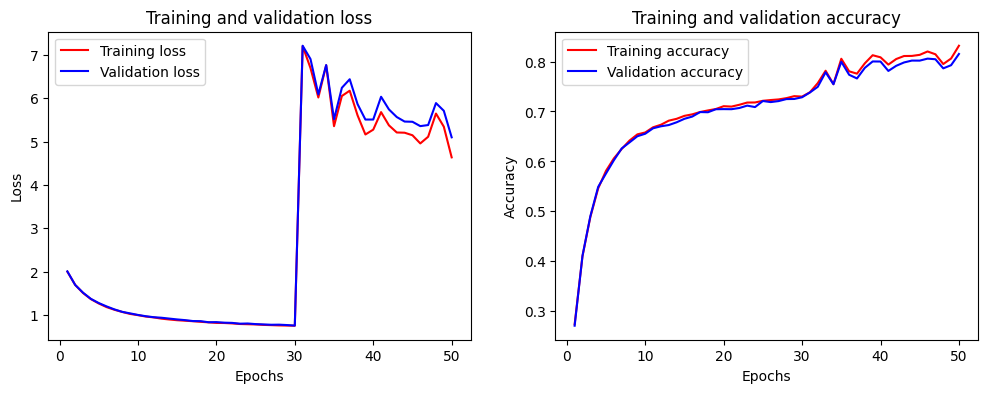

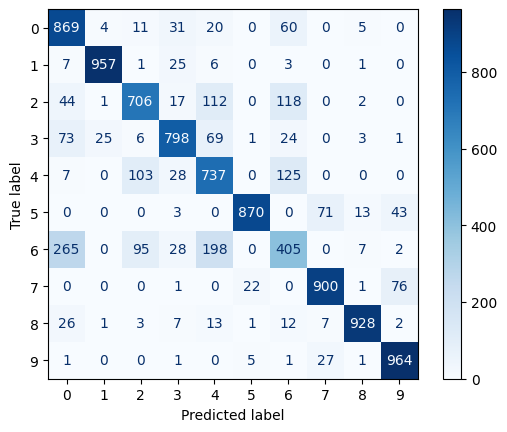

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Downloading the Fashion_MNIST dataset
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 80-20 split for training and validation sets
train_length = int(0.8 * len(dataset))
val_length = len(dataset) - train_length

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

# PyTorch DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Printing the dataset sizes
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

def prepare_data(loader):
    x_list, y_list = [], []
    for x, y in loader:
        x_list.append(x.view(x.size(0), -1).numpy())
        y_list.append(np.eye(10)[y.numpy()])
    return np.vstack(x_list), np.vstack(y_list)

x_train, y_train = prepare_data(train_loader)
x_val, y_val = prepare_data(val_loader)
x_test, y_test = prepare_data(test_loader)

# Define the MLP class (assuming it has been defined as in the previous implementation)

# Initialize and train the model
input_size = 28 * 28
hidden_sizes = [256, 128, 64]
output_size = 10
learning_rate = 0.01
mlp = MLP(input_size, hidden_sizes, output_size, learning_rate)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = mlp.train(x_train, y_train, x_val, y_val, epochs=50)

# Evaluate the model on the test dataset
test_loss, test_accuracy = mlp.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotting results
import matplotlib.pyplot as plt

epochs = range(1, 51)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_test = mlp.predict(x_test)
y_true_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()


Training set size: 48000
Validation set size: 12000
Test set size: 10000
Epoch 1/50, Train Loss: 6.7671, Val Loss: 6.9876, Train Acc: 0.7544, Val Acc: 0.7466
Epoch 2/50, Train Loss: 6.8666, Val Loss: 6.8497, Train Acc: 0.7504, Val Acc: 0.7507
Epoch 3/50, Train Loss: 6.8131, Val Loss: 6.8281, Train Acc: 0.7524, Val Acc: 0.7518
Epoch 4/50, Train Loss: 6.4748, Val Loss: 6.5313, Train Acc: 0.7642, Val Acc: 0.7625
Epoch 5/50, Train Loss: 6.4051, Val Loss: 6.4456, Train Acc: 0.7668, Val Acc: 0.7656
Epoch 6/50, Train Loss: 6.3062, Val Loss: 6.2830, Train Acc: 0.7706, Val Acc: 0.7711
Epoch 7/50, Train Loss: 5.9435, Val Loss: 6.0488, Train Acc: 0.7838, Val Acc: 0.7796
Epoch 8/50, Train Loss: 5.9623, Val Loss: 5.9798, Train Acc: 0.7831, Val Acc: 0.7827
Epoch 9/50, Train Loss: 6.2126, Val Loss: 6.3934, Train Acc: 0.7738, Val Acc: 0.7672
Epoch 10/50, Train Loss: 5.7996, Val Loss: 5.9493, Train Acc: 0.7890, Val Acc: 0.7837
Epoch 11/50, Train Loss: 5.7588, Val Loss: 5.8633, Train Acc: 0.7906, Val Ac

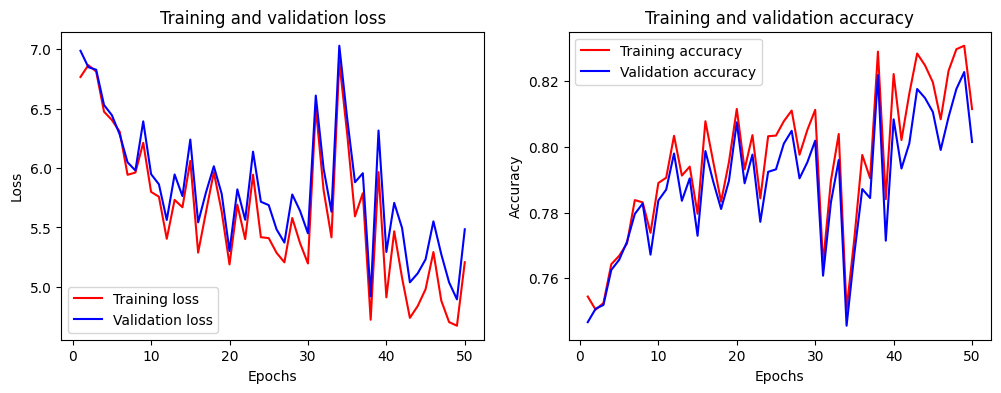

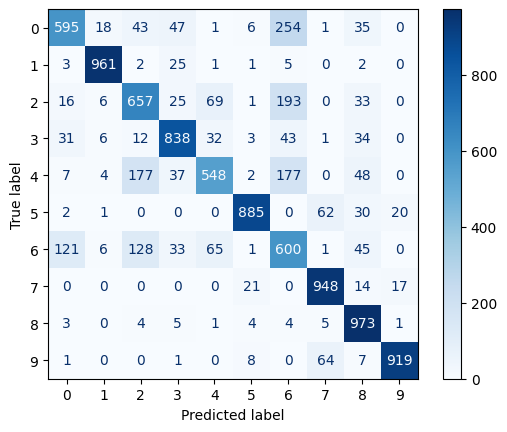

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Downloading the Fashion_MNIST dataset
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 80-20 split for training and validation sets
train_length = int(0.8 * len(dataset))
val_length = len(dataset) - train_length

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

# PyTorch DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Checking the dataset sizes
print(f'Training set size: {len(train_dataset)}')  # Should be 80% of 60,000
print(f'Validation set size: {len(val_dataset)}')  # Should be 20% of 60,000
print(f'Test set size: {len(test_dataset)}')       # Should be 10,000

# Implementing functions from scratch using numpy

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-12, 1.0)
    log_p = -np.log(y_pred[range(n_samples), y_true.argmax(axis=1)])
    loss = np.sum(log_p) / n_samples
    return loss

def cross_entropy_loss_derivative(y_true, y_pred):
    n_samples = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(n_samples), y_true.argmax(axis=1)] -= 1
    grad = grad / n_samples
    return grad

def batch_norm_forward(x, gamma, beta, eps=1e-8):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    x_norm = (x - mean) / np.sqrt(var + eps)
    out = gamma * x_norm + beta
    cache = (x, x_norm, mean, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    x, x_norm, mean, var, gamma, beta, eps = cache
    N, D = x.shape

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_norm, axis=0)
    dx_norm = dout * gamma
    dvar = np.sum(dx_norm * (x - mean) * -0.5 * np.power(var + eps, -1.5), axis=0)
    dmean = np.sum(dx_norm * -1.0 / np.sqrt(var + eps), axis=0) + dvar * np.sum(-2.0 * (x - mean), axis=0) / N
    dx = dx_norm * 1.0 / np.sqrt(var + eps) + dvar * 2.0 * (x - mean) / N + dmean / N

    return dx, dgamma, dbeta

# Implement MLP class

class MLP_FM:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, dropout_rates=None):
        self.learning_rate = learning_rate
        self.dropout_rates = dropout_rates if dropout_rates else [0.1] * (len(hidden_sizes) + 1)
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.gammas = [np.ones((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.betas = [np.zeros((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.velocities = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]
        self.squares = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]

    def forward(self, x):
        self.caches = []
        self.norm_caches = []
        self.dropouts = []

        x = x * (np.random.rand(*x.shape) > self.dropout_rates[0]) / (1 - self.dropout_rates[0])
        self.dropouts.append(x)

        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            norm_z, norm_cache = batch_norm_forward(z, self.gammas[i], self.betas[i])
            a = leaky_relu(norm_z)
            dropout_mask = (np.random.rand(*a.shape) > self.dropout_rates[i+1]) / (1 - self.dropout_rates[i+1])
            a = a * dropout_mask
            self.caches.append((x, z, norm_cache))
            self.dropouts.append(dropout_mask)
            x = a

        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        a = softmax(z)
        self.caches.append((x, z))
        return a

    def backward(self, y_true, y_pred):
        m = y_true.shape[0]
        grads = {}
        d_a = cross_entropy_loss_derivative(y_true, y_pred)

        for i in reversed(range(len(self.weights))):
            x, z, *cache = self.caches[i]
            if i == len(self.weights) - 1:
                d_z = d_a
            else:
                d_z = d_a * leaky_relu_derivative(z)
                d_z, dgamma, dbeta = batch_norm_backward(d_z, cache[0])
                grads[f'dgamma{i}'] = dgamma
                grads[f'dbeta{i}'] = dbeta

            grads[f'dw{i}'] = np.dot(x.T, d_z) / m
            grads[f'db{i}'] = np.sum(d_z, axis=0, keepdims=True) / m

            if i != 0:
                d_a = np.dot(d_z, self.weights[i].T)
                if len(self.dropouts) > i:
                    d_a = d_a * self.dropouts[i]

        return grads

    def update_weights(self, grads, t, optimizer='adam'):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        lr = self.learning_rate
        for i in range(len(self.weights)):
            if optimizer == 'adam':
                self.velocities[i]['dw'] = beta1 * self.velocities[i]['dw'] + (1 - beta1) * grads[f'dw{i}']
                self.velocities[i]['db'] = beta1 * self.velocities[i]['db'] + (1 - beta1) * grads[f'db{i}']
                self.squares[i]['dw'] = beta2 * self.squares[i]['dw'] + (1 - beta2) * (grads[f'dw{i}'] ** 2)
                self.squares[i]['db'] = beta2 * self.squares[i]['db'] + (1 - beta2) * (grads[f'db{i}'] ** 2)
                m_hat_dw = self.velocities[i]['dw'] / (1 - beta1 ** t)
                m_hat_db = self.velocities[i]['db'] / (1 - beta1 ** t)
                v_hat_dw = self.squares[i]['dw'] / (1 - beta2 ** t)
                v_hat_db = self.squares[i]['db'] / (1 - beta2 ** t)
                self.weights[i] -= lr * m_hat_dw / (np.sqrt(v_hat_dw) + eps)
                self.biases[i] -= lr * m_hat_db / (np.sqrt(v_hat_db) + eps)
                if i < len(self.weights) - 1:
                    v_hat_gamma = self.squares[i]['dgamma'] / (1 - beta2 ** t)
                    v_hat_beta = self.squares[i]['dbeta'] / (1 - beta2 ** t)
                    self.gammas[i] -= lr * grads[f'dgamma{i}'] / (np.sqrt(v_hat_gamma) + eps)
                    self.betas[i] -= lr * grads[f'dbeta{i}'] / (np.sqrt(v_hat_beta) + eps)
            else:  # SGD
                self.weights[i] -= lr * grads[f'dw{i}']
                self.biases[i] -= lr * grads[f'db{i}']
                if i < len(self.weights) - 1:
                    self.gammas[i] -= lr * grads[f'dgamma{i}']
                    self.betas[i] -= lr * grads[f'dbeta{i}']

    def train(self, x_train, y_train, x_val, y_val, epochs=30, batch_size=128):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            optimizer = 'adam' if epoch < 30 else 'sgd'  # Switch to SGD after 30 epochs
            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward(x_batch)
                grads = self.backward(y_batch, y_pred)
                self.update_weights(grads, epoch + 1, optimizer=optimizer)

            train_loss, train_acc = self.evaluate(x_train, y_train)
            val_loss, val_acc = self.evaluate(x_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        return train_losses, val_losses, train_accuracies, val_accuracies

    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == y.argmax(axis=1))
        return loss, accuracy

    def predict(self, x):
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)

def prepare_data(loader):
    x_list, y_list = [], []
    for x, y in loader:
        x_list.append(x.view(x.size(0), -1).numpy())  # Flattening the images
        y_list.append(np.eye(10)[y.numpy()])  # One-hot encoding the labels
    return np.vstack(x_list), np.vstack(y_list)

x_train, y_train = prepare_data(train_loader)
x_val, y_val = prepare_data(val_loader)
x_test, y_test = prepare_data(test_loader)

# Instantiate and train the MLP
input_size = 28 * 28
hidden_sizes = [128]
output_size = 10
learning_rate = 0.01
mlp = MLP_FM(input_size, hidden_sizes, output_size, learning_rate)

train_losses, val_losses, train_accuracies, val_accuracies = mlp.train(x_train, y_train, x_val, y_val, epochs=50)

# Evaluate the model on the test dataset
test_loss, test_accuracy = mlp.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotting results
epochs = range(1, 51)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_test = mlp.predict(x_test)
y_true_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()


Best result so far - This is using activation function Relu and with small weight initialization and simple model with 1 hidden layer - 128 neurons - 89% accuracy

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Downloading the Fashion_MNIST dataset
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 80-20 split for training and validation sets
train_length = int(0.8 * len(dataset))
val_length = len(dataset) - train_length

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

# PyTorch DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Checking the dataset sizes
print(f'Training set size: {len(train_dataset)}')  # Should be 80% of 60,000
print(f'Validation set size: {len(val_dataset)}')  # Should be 20% of 60,000
print(f'Test set size: {len(test_dataset)}')       # Should be 10,000

class RevisedMLP_FM:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        A2 = self.softmax(self.Z2)
        return A2

    def backward(self, X, y, output):
        m = y.shape[0]
        y_one_hot = np.eye(self.output_size)[y]

        dZ2 = output - y_one_hot
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def compute_loss(self, output, y):
        m = y.shape[0]
        y_one_hot = np.eye(self.output_size)[y]
        log_probs = -np.log(output[range(m), y])
        loss = np.sum(log_probs) / m
        return loss

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

    def accuracy(self, predictions, labels):
        return np.mean(predictions == labels)

def flatten_images(images):
    return images.view(images.size(0), -1).numpy()

def train_mlp(model, train_loader, val_loader, epochs=50, learning_rate=0.01):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model_train_loss = 0
        model_train_acc = 0
        for batch in train_loader:
            images, labels = batch
            images = flatten_images(images)
            labels = labels.numpy()

            outputs = model.forward(images)
            loss = model.compute_loss(outputs, labels)
            model_train_loss += loss
            model_train_acc += model.accuracy(model.predict(images), labels)

            model.backward(images, labels, outputs)

        model_train_loss /= len(train_loader)
        model_train_acc /= len(train_loader)
        train_losses.append(model_train_loss)
        train_accuracies.append(model_train_acc)

        val_loss = 0
        val_acc = 0
        for batch in val_loader:
            images, labels = batch
            images = flatten_images(images)
            labels = labels.numpy()

            outputs = model.forward(images)
            loss = model.compute_loss(outputs, labels)
            val_loss += loss
            val_acc += model.accuracy(model.predict(images), labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Training Loss: {model_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {model_train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, data_loader):
    all_labels = []
    all_predictions = []
    total_loss = 0
    for batch in data_loader:
        images, labels = batch
        images = flatten_images(images)
        labels = labels.numpy()
        outputs = model.forward(images)
        loss = model.compute_loss(outputs, labels)
        total_loss += loss
        predictions = model.predict(images)
        all_labels.extend(labels)
        all_predictions.extend(predictions)
    total_loss /= len(data_loader)
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    accuracy = model.accuracy(all_predictions, all_labels)
    report = classification_report(all_labels, all_predictions, output_dict=True)
    return total_loss, accuracy, report

# Example usage
input_size = 28 * 28
hidden_size = 128  # Single hidden layer with 128 units
output_size = 10
mlp_model = RevisedMLP_FM(input_size, hidden_size, output_size, learning_rate=0.01)

train_losses, val_losses, train_accuracies, val_accuracies = train_mlp(mlp_model, train_loader, val_loader, epochs=50, learning_rate=0.01)

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_report = evaluate_model(mlp_model, test_loader)
train_loss, train_accuracy, train_report = evaluate_model(mlp_model, train_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')



Training set size: 48000
Validation set size: 12000
Test set size: 10000
Epoch 1, Training Loss: 1.1690, Validation Loss: 0.6916, Training Accuracy: 0.6127, Validation Accuracy: 0.7567
Epoch 2, Training Loss: 0.6226, Validation Loss: 0.5709, Training Accuracy: 0.7719, Validation Accuracy: 0.7984
Epoch 3, Training Loss: 0.5391, Validation Loss: 0.5110, Training Accuracy: 0.8073, Validation Accuracy: 0.8209
Epoch 4, Training Loss: 0.4954, Validation Loss: 0.4806, Training Accuracy: 0.8247, Validation Accuracy: 0.8329
Epoch 5, Training Loss: 0.4692, Validation Loss: 0.4646, Training Accuracy: 0.8356, Validation Accuracy: 0.8364
Epoch 6, Training Loss: 0.4504, Validation Loss: 0.4486, Training Accuracy: 0.8412, Validation Accuracy: 0.8425
Epoch 7, Training Loss: 0.4354, Validation Loss: 0.4382, Training Accuracy: 0.8463, Validation Accuracy: 0.8449
Epoch 8, Training Loss: 0.4231, Validation Loss: 0.4267, Training Accuracy: 0.8496, Validation Accuracy: 0.8507
Epoch 9, Training Loss: 0.4126,

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

Graph with lr = 0.01  epoch 50

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.79      0.81      0.80      1000
           3       0.85      0.91      0.88      1000
           4       0.80      0.80      0.80      1000
           5       0.96      0.94      0.95      1000
           6       0.73      0.67      0.70      1000
           7       0.93      0.93      0.93      1000
           8       0.96      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



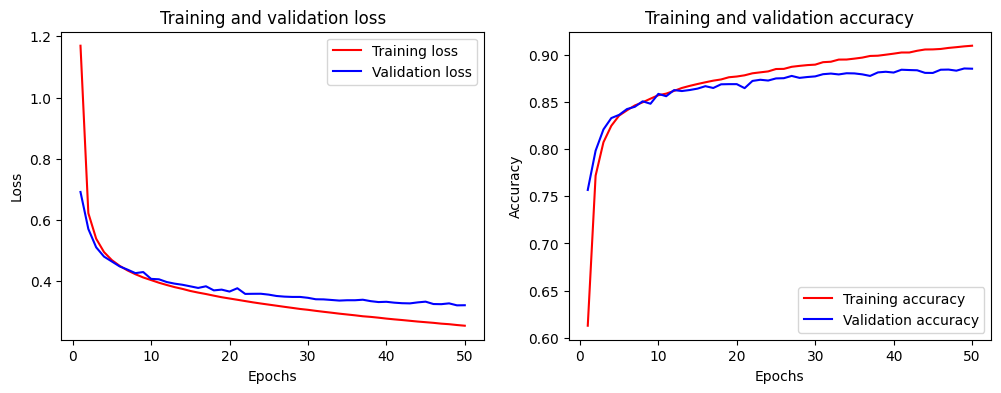

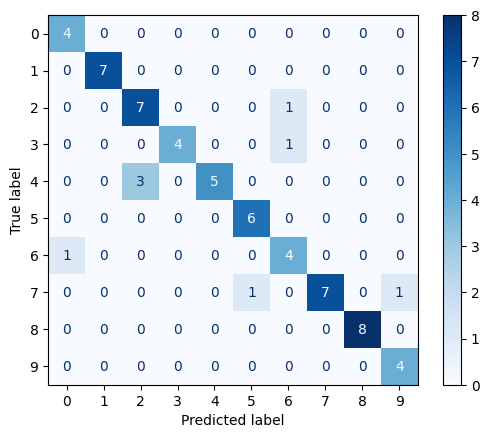

Percentage difference in accuracy between training and test data: 3.88%


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate the model on the test dataset and get true and predicted labels
def get_true_pred_labels(model, data_loader):
    all_labels = []
    all_predictions = []
    for batch in data_loader:
        images, labels = batch
        images = flatten_images(images)
        labels = labels.numpy()
        predictions = model.predict(images)
        all_labels.extend(labels)
        all_predictions.extend(predictions)
    return np.array(all_labels), np.array(all_predictions)

# Get true and predicted labels for test set
y_true_test, y_pred_test = get_true_pred_labels(mlp_model, test_loader)

# Compute and print additional metrics
print("Classification Report on Test Data:")
print(classification_report(y_true_test, y_pred_test))

epochs = range(1, 51)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
y_pred_test = mlp_model.predict(flatten_images(next(iter(test_loader))[0]))
y_true_test = next(iter(test_loader))[1].numpy()
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calculate percentage difference
percentage_difference_accuracy = abs(train_accuracy - test_accuracy) / train_accuracy * 100
print(f'Percentage difference in accuracy between training and test data: {percentage_difference_accuracy:.2f}%')


In [ ]:
#with lr =0.001


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Downloading the Fashion_MNIST dataset
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 80-20 split for training and validation sets
train_length = int(0.8 * len(dataset))
val_length = len(dataset) - train_length

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

# PyTorch DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Checking the dataset sizes
print(f'Training set size: {len(train_dataset)}')  # Should be 80% of 60,000
print(f'Validation set size: {len(val_dataset)}')  # Should be 20% of 60,000
print(f'Test set size: {len(test_dataset)}')       # Should be 10,000

class RevisedMLP_FM:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        A2 = self.softmax(self.Z2)
        return A2

    def backward(self, X, y, output):
        m = y.shape[0]
        y_one_hot = np.eye(self.output_size)[y]

        dZ2 = output - y_one_hot
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def compute_loss(self, output, y):
        m = y.shape[0]
        y_one_hot = np.eye(self.output_size)[y]
        log_probs = -np.log(output[range(m), y])
        loss = np.sum(log_probs) / m
        return loss

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

    def accuracy(self, predictions, labels):
        return np.mean(predictions == labels)

def flatten_images(images):
    return images.view(images.size(0), -1).numpy()

def train_mlp(model, train_loader, val_loader, epochs=50, learning_rate=0.01):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model_train_loss = 0
        model_train_acc = 0
        for batch in train_loader:
            images, labels = batch
            images = flatten_images(images)
            labels = labels.numpy()

            outputs = model.forward(images)
            loss = model.compute_loss(outputs, labels)
            model_train_loss += loss
            model_train_acc += model.accuracy(model.predict(images), labels)

            model.backward(images, labels, outputs)

        model_train_loss /= len(train_loader)
        model_train_acc /= len(train_loader)
        train_losses.append(model_train_loss)
        train_accuracies.append(model_train_acc)

        val_loss = 0
        val_acc = 0
        for batch in val_loader:
            images, labels = batch
            images = flatten_images(images)
            labels = labels.numpy()

            outputs = model.forward(images)
            loss = model.compute_loss(outputs, labels)
            val_loss += loss
            val_acc += model.accuracy(model.predict(images), labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Training Loss: {model_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {model_train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, data_loader):
    all_labels = []
    all_predictions = []
    total_loss = 0
    for batch in data_loader:
        images, labels = batch
        images = flatten_images(images)
        labels = labels.numpy()
        outputs = model.forward(images)
        loss = model.compute_loss(outputs, labels)
        total_loss += loss
        predictions = model.predict(images)
        all_labels.extend(labels)
        all_predictions.extend(predictions)
    total_loss /= len(data_loader)
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    accuracy = model.accuracy(all_predictions, all_labels)
    report = classification_report(all_labels, all_predictions, output_dict=True)
    return total_loss, accuracy, report

# Example usage
input_size = 28 * 28
hidden_size = 128  # Single hidden layer with 128 units
output_size = 10
mlp_model = RevisedMLP_FM(input_size, hidden_size, output_size, learning_rate=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train_mlp(mlp_model, train_loader, val_loader, epochs=30, learning_rate=0.001)

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_report = evaluate_model(mlp_model, test_loader)
train_loss, train_accuracy, train_report = evaluate_model(mlp_model, train_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')



Training set size: 48000
Validation set size: 12000
Test set size: 10000
Epoch 1, Training Loss: 2.2452, Validation Loss: 2.1432, Training Accuracy: 0.2463, Validation Accuracy: 0.3276
Epoch 2, Training Loss: 1.9224, Validation Loss: 1.6899, Training Accuracy: 0.3663, Validation Accuracy: 0.4345
Epoch 3, Training Loss: 1.4923, Validation Loss: 1.3244, Training Accuracy: 0.5265, Validation Accuracy: 0.5987
Epoch 4, Training Loss: 1.2025, Validation Loss: 1.1004, Training Accuracy: 0.6405, Validation Accuracy: 0.6702
Epoch 5, Training Loss: 1.0216, Validation Loss: 0.9563, Training Accuracy: 0.6886, Validation Accuracy: 0.7082
Epoch 6, Training Loss: 0.9042, Validation Loss: 0.8628, Training Accuracy: 0.7136, Validation Accuracy: 0.7266
Epoch 7, Training Loss: 0.8264, Validation Loss: 0.7989, Training Accuracy: 0.7255, Validation Accuracy: 0.7345
Epoch 8, Training Loss: 0.7732, Validation Loss: 0.7540, Training Accuracy: 0.7341, Validation Accuracy: 0.7447
Epoch 9, Training Loss: 0.7351,

In [ ]:
#Plot the graph with lr = 0.001

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1000
           1       0.97      0.93      0.95      1000
           2       0.73      0.68      0.70      1000
           3       0.79      0.86      0.82      1000
           4       0.70      0.74      0.72      1000
           5       0.87      0.88      0.88      1000
           6       0.53      0.49      0.51      1000
           7       0.87      0.87      0.87      1000
           8       0.92      0.92      0.92      1000
           9       0.89      0.92      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



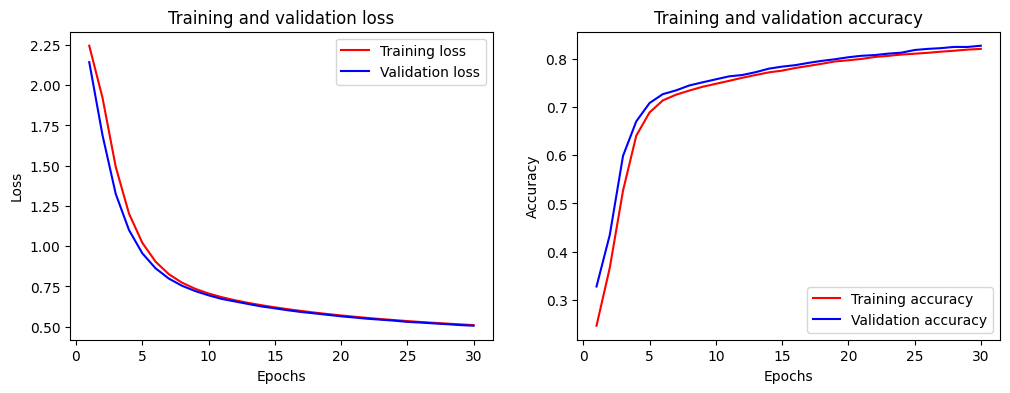

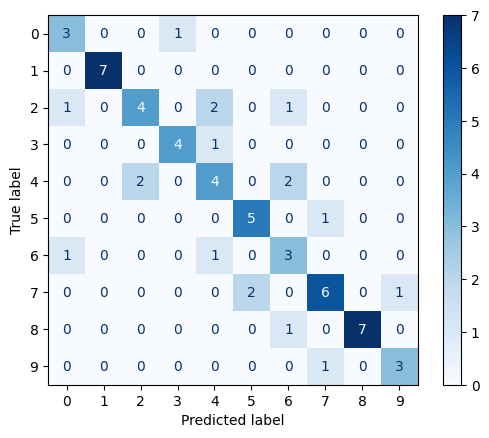

Percentage difference in accuracy between training and test data: 1.51%


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate the model on the test dataset and get true and predicted labels
def get_true_pred_labels(model, data_loader):
    all_labels = []
    all_predictions = []
    for batch in data_loader:
        images, labels = batch
        images = flatten_images(images)
        labels = labels.numpy()
        predictions = model.predict(images)
        all_labels.extend(labels)
        all_predictions.extend(predictions)
    return np.array(all_labels), np.array(all_predictions)

# Get true and predicted labels for test set
y_true_test, y_pred_test = get_true_pred_labels(mlp_model, test_loader)

# Compute and print additional metrics
print("Classification Report on Test Data:")
print(classification_report(y_true_test, y_pred_test))

epochs = range(1, 31)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
y_pred_test = mlp_model.predict(flatten_images(next(iter(test_loader))[0]))
y_true_test = next(iter(test_loader))[1].numpy()
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calculate percentage difference
percentage_difference_accuracy = abs(train_accuracy - test_accuracy) / train_accuracy * 100
print(f'Percentage difference in accuracy between training and test data: {percentage_difference_accuracy:.2f}%')
